<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/code/SS/SS_unet_matrixlonlatcov_20_20_15s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dive Prediction - Deep Network

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a neural network to predict seabirds' dives.

Networks' characteristics:

* *Trajectory window* : 60 x 5s
* *Output resolution*: 60 x 5s
* *Representation of trajectories* : Matrix Distance and Time series
* *Layers* : convolutions

## connect to drive

In [39]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [40]:
%cd drive/My\ Drive/

[Errno 2] No such file or directory: 'drive/My Drive/'
/content/drive/My Drive


## load data

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import * 

In [42]:
data_train = pd.read_csv('./data/SS_train.csv')
data_test = pd.read_csv('./data/SS_test.csv')

In [43]:
data_train = standardize_data(data_train)
data_test = standardize_data(data_test)

data_train.head()

,datetime,trip,lon,lat,step_speed,step_direction,gaps,pressure,dive,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
0,2015-10-03 05:45:26,F0915_23_SS_T1,-32.392269,-3.822563,11.399404,-6.153640,0.0,0.81,0,-2.823660,-1.899305,0.735775,0.994238,-0.107195
1,2015-10-03 05:45:41,F0915_23_SS_T1,-32.391787,-3.820678,14.429657,2.260084,0.0,0.81,0,-2.816237,-1.862055,0.931363,0.999222,0.039436
2,2015-10-03 05:45:56,F0915_23_SS_T1,-32.390905,-3.819401,11.517573,20.269715,0.0,0.81,0,-2.802631,-1.836792,0.743403,0.938072,0.346440
3,2015-10-03 05:46:11,F0915_23_SS_T1,-32.390194,-3.817870,12.517428,-9.715169,0.0,0.81,0,-2.791676,-1.806535,0.807938,0.985659,-0.168750
4,2015-10-03 05:46:26,F0915_23_SS_T1,-32.389443,-3.816594,10.981969,5.562869,0.0,0.87,0,-2.780100,-1.781307,0.708832,0.995290,0.096938


## No fine-tuning

In [44]:
# hyperparameters
batch_size = 64
window = 20
variable = ('lon_std', 'lat_std', 'gaps')

## reduce size dataset
train_set = TrajDataSet(data_train, window, variable, transform = ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [45]:
class UNet(nn.Module):

    def __init__(self):
        super(UNet, self).__init__()

        self.threshold = nn.Sequential(
#             nn.BatchNorm2d(1),
            nn.Conv2d(1, 8, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True),
            nn.ReLU()
        )

        self.cnn_input_1 = nn.Sequential(
            nn.BatchNorm1d(8+3),
            nn.Conv1d(8+3, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_1 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 5, stride = 2, padding = 2, dilation = 1)
        )

        self.cnn_input_2 = nn.Sequential(
            nn.BatchNorm1d(8),
            nn.Conv1d(8, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_2 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 5, stride = 2, padding = 2, dilation = 1)
        )

        self.cnn_input_3 = nn.Sequential(
            nn.BatchNorm1d(16),
            nn.Conv1d(16, 32,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(32, 32,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.upconv_2 = nn.Sequential(
             nn.ConvTranspose1d(32, 16, kernel_size = 6, stride = 2, padding = 2, dilation = 1)
         )

        self.cnn_output_2 = nn.Sequential(
            nn.BatchNorm1d(16*2),
            nn.Conv1d(16*2, 16,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.upconv_1 = nn.Sequential(
             nn.ConvTranspose1d(16, 8, kernel_size = 6, stride = 2, padding = 2, dilation = 1)
         )
        
        self.cnn_output_1 = nn.Sequential(
            nn.BatchNorm1d(8*2),
            nn.Conv1d(8*2, 8,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 4, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(4, 2, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(2, 1,  kernel_size = 5, stride = 1, padding = 2, dilation = 1)
        )

    def forward(self, x, y):
        out = self.threshold(y)
        out = torch.sum(out, 2)

        out = torch.cat((out, x.squeeze(1)), 1)

        out_1 = self.cnn_input_1(out)
        out = self.pooling_1(out_1)
        out_2 = self.cnn_input_2(out)
        out = self.pooling_2(out_2)
        out = self.cnn_input_3(out)

        out = self.upconv_2(out)
        out = torch.cat((out, out_2), 1)
        out = self.cnn_output_2(out)

        out = self.upconv_1(out)
        out = torch.cat((out, out_1), 1)
        out = self.cnn_output_1(out)


        return out

def get_score(out, y):
    out, y = out.cpu(), y.cpu()
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))

In [46]:
model = torch.load('./SV_unet_matrixlonlatcov_15s.pt')

In [47]:
dive_estim = []

for i in data_test.trip.unique():
    t = data_test[data_test.trip == i].copy()
        
    test_set = TrajDataSet(t, window, variable, transform = ToTensor())
    
    # Test the model
    estim = np.zeros(len(t))
    nb = np.zeros(len(t))
    
    list_out = []
    model.eval()
    k = 0
    with torch.no_grad():
        for (x, y, z) in test_set:

            # Run the forward pass
            out = model(x, y.unsqueeze(1))
            
            estim[k:k + round(window)] += out.cpu().squeeze().numpy()
            nb[k:k + round(window)] += 1
            k+=1
    # # add to list by trajectory
    dive_estim.append(estim/nb)
    print(i)

data_test['prediction_no'] = 1/(1+np.exp(-np.hstack(dive_estim)))

F0915_14_SS_T1
F0915_23_SS_T2
F0915_24_SS_T1
F0916_15_SS_T1
F0916_16_SS_T2


0.5839794999272351

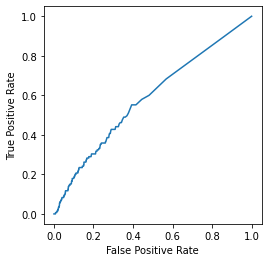

In [48]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# globally
TP = []
FP = []

for tt in np.arange(0,1,0.001):
    all_estim = 1* (data_test.prediction_no > tt)
    true_positive = np.mean(all_estim[data_test.dive == 1])
    true_negative = 1-np.mean(all_estim[data_test.dive == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

plt.plot(np.array(FP), np.array(TP))
-np.trapz(TP, FP)

# Fine-tuning

In [49]:
# Loss and score
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
weight = torch.FloatTensor([50])
criterion = nn.BCEWithLogitsLoss(pos_weight = weight)

In [50]:
# Train the model
nb_epoch = 1

global_loss_train = []

for epoch in range(nb_epoch):
    i = 0
    for batch, (x, y, z) in enumerate(train_loader):
        i+=1

        # Run the forward pass
        out = model(x, y)
        loss = criterion(out, z)
        
        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    ### Evaluation + Validation every epoch
    model.eval()
    with torch.no_grad():      
        j = 0
        # evaluation
        list_loss_train = []
        list_score_train = []
        for batch, (x, y, z) in enumerate(train_loader):
            j+= 1

            # Run the forward pass
            out =  model(x, y)
            loss = criterion(out, z)
            list_loss_train.append(loss.item())
        
        train_loss = np.mean(list_loss_train)

    print('Epoch [{}/{}] -------------------------------------------------------------------------------------'
          .format(epoch+1, nb_epoch))
    print('Train Loss: {}'.format(round(train_loss, 2)))
    model.train()
    
    global_loss_train.append(train_loss)


Epoch [1/1] -------------------------------------------------------------------------------------
Train Loss: 0.22


In [51]:
dive_estim = []

for i in data_test.trip.unique():
    t = data_test[data_test.trip == i].copy()
        
    test_set = TrajDataSet(t, window, variable, transform = ToTensor())
    
    # Test the model
    estim = np.zeros(len(t))
    nb = np.zeros(len(t))
    
    list_out = []
    model.eval()
    k = 0
    with torch.no_grad():
        for (x, y, z) in test_set:

            # Run the forward pass
            out = model(x, y.unsqueeze(1))
            
            estim[k:k + round(window)] += out.cpu().squeeze().numpy()
            nb[k:k + round(window)] += 1
            k+=1
    # # add to list by trajectory
    dive_estim.append(estim/nb)
    print(i)

data_test['prediction_ft'] = 1/(1+np.exp(-np.hstack(dive_estim)))

F0915_14_SS_T1
F0915_23_SS_T2
F0915_24_SS_T1
F0916_15_SS_T1
F0916_16_SS_T2


0.644143988231731

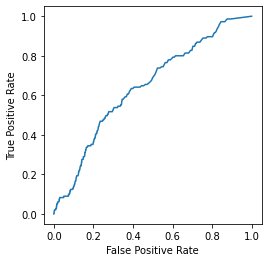

In [52]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# globally
TP = []
FP = []

for tt in np.arange(0,1,0.001):
    all_estim = 1* (data_test.prediction_ft > tt)
    true_positive = np.mean(all_estim[data_test.dive == 1])
    true_negative = 1-np.mean(all_estim[data_test.dive == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

plt.plot(np.array(FP), np.array(TP))
-np.trapz(TP, FP)

In [53]:
torch.save(model, './SS_unet_matrixlonlatcov_15s.pt')

# from scratch

In [54]:
model = UNet()

In [55]:
# Train the model
nb_epoch = 1

global_loss_train = []

for epoch in range(nb_epoch):
    i = 0
    for batch, (x, y, z) in enumerate(train_loader):
        i+=1

        # Run the forward pass
        out = model(x, y)
        loss = criterion(out, z)
        
        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    ### Evaluation + Validation every epoch
    model.eval()
    with torch.no_grad():      
        j = 0
        # evaluation
        list_loss_train = []
        list_score_train = []
        for batch, (x, y, z) in enumerate(train_loader):
            j+= 1

            # Run the forward pass
            out =  model(x, y)
            loss = criterion(out, z)
            list_loss_train.append(loss.item())
        
        train_loss = np.mean(list_loss_train)

    print('Epoch [{}/{}] -------------------------------------------------------------------------------------'
          .format(epoch+1, nb_epoch))
    print('Train Loss: {}'.format(round(train_loss, 2)))
    model.train()
    
    global_loss_train.append(train_loss)


Epoch [1/1] -------------------------------------------------------------------------------------
Train Loss: 0.71


In [56]:
dive_estim = []

for i in data_test.trip.unique():
    t = data_test[data_test.trip == i].copy()
        
    test_set = TrajDataSet(t, window, variable, transform = ToTensor())
    
    # Test the model
    estim = np.zeros(len(t))
    nb = np.zeros(len(t))
    
    list_out = []
    model.eval()
    k = 0
    with torch.no_grad():
        for (x, y, z) in test_set:

            # Run the forward pass
            out = model(x, y.unsqueeze(1))
            
            estim[k:k + round(window)] += out.cpu().squeeze().numpy()
            nb[k:k + round(window)] += 1
            k+=1
    # # add to list by trajectory
    dive_estim.append(estim/nb)
    print(i)

data_test['prediction_fs'] = 1/(1+np.exp(-np.hstack(dive_estim)))

F0915_14_SS_T1
F0915_23_SS_T2
F0915_24_SS_T1
F0916_15_SS_T1
F0916_16_SS_T2


0.3949359471057217

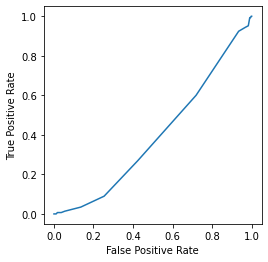

In [57]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# globally
TP = []
FP = []

for tt in np.arange(0,1,0.001):
    all_estim = 1* (data_test.prediction_fs > tt)
    true_positive = np.mean(all_estim[data_test.dive == 1])
    true_negative = 1-np.mean(all_estim[data_test.dive == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

plt.plot(np.array(FP), np.array(TP))
-np.trapz(TP, FP)

In [58]:

data_test.to_csv('SS_unet_matrixlonlatcov_15s.csv', index = False)